In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [21]:
train_df = pd.read_csv("cleaned_train.csv")
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,6,0,Multifamily_Uncategorized,76772.0,1931.0,59.0,25.0,11,34.451613,59,...,0,0,87.859290,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6,0,Multifamily_Uncategorized,84757.0,2007.0,46.0,42.7,11,34.451613,59,...,0,0,63.924863,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6,0,Multifamily_Uncategorized,65862.0,1930.0,45.0,25.0,11,34.451613,59,...,0,0,104.314208,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1,Office_Uncategorized,240578.0,2000.0,69.0,47.5,3,28.290323,59,...,0,0,72.833560,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6,0,Multifamily_Uncategorized,85000.0,1950.0,74.0,24.4,11,34.451613,59,...,0,0,71.304645,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
test_df = pd.read_csv("cleaned_test.csv")
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,3,1,Office_Uncategorized,184405.0,1917.0,72.0,15.2,11,35.080645,61,...,0,0,56.637582,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4,1,Office_Uncategorized,736974.0,1960.0,55.0,42.7,4,28.596774,58,...,0,0,106.618289,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,1,Lodging_Hotel,233230.0,1989.0,13.0,3.4,13,37.322581,62,...,0,0,96.635246,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0,2to4_Unit_Building,25301.0,1988.0,80.0,18.3,28,45.419355,63,...,0,0,26.990755,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6,0,5plus_Unit_Building,28350.0,1999.0,96.0,26.5,28,43.451613,56,...,0,0,44.738108,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
y_train = train_df['site_eui']
X_train = train_df.drop(columns = ['site_eui','facility_type'])
y_test = test_df['site_eui']
X_test = test_df.drop(columns = ['site_eui','facility_type'])

In [5]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [6]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 629.8504


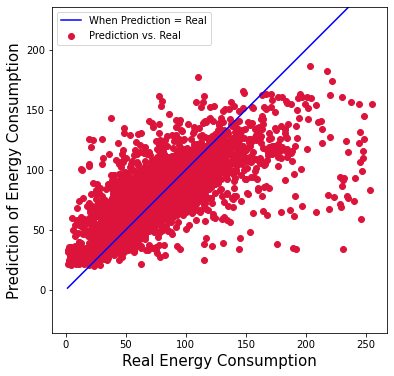

In [7]:
y_pred = reg.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, c='crimson', label="Prediction vs. Real")

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label="When Prediction = Real")
plt.xlabel('Real Energy Consumption', fontsize=15)
plt.ylabel('Prediction of Energy Consumption', fontsize=15)
plt.axis('equal')
plt.ylim(0, 200)

plt.legend(loc="upper left")

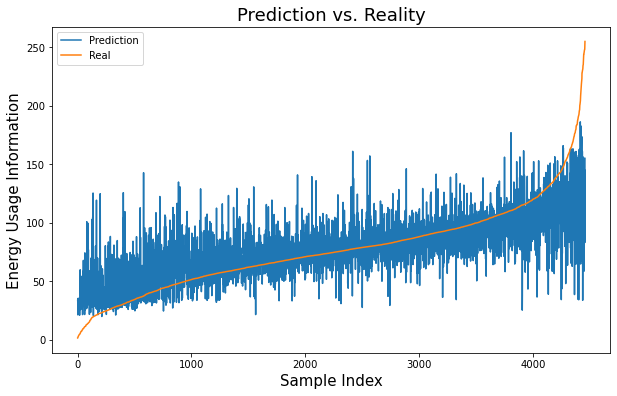

In [8]:
df_pred_real=y_test.to_frame()
df_pred_real['Pred'] = y_pred.tolist()
df_pred_real.rename({'site_eui':'Real'}, axis='columns',inplace=True)

# Sort our dataframe in an ascending order
df_pred_real= df_pred_real.sort_values('Real',ascending=True)
df_pred_real.reset_index(inplace=True)

# Set labels and title, and reset the index
plt.figure(figsize=(10,6))
plt.xlabel('Sample Index', size=15)
plt.ylabel('Energy Usage Information', size=15)
plt.title('Prediction vs. Reality', size=18)

# Plot prediction y_pred
plt.plot(df_pred_real.index, df_pred_real['Pred'],label='Prediction')
plt.plot(df_pred_real.index, df_pred_real['Real'],label='Real')

plt.legend()

# Save plot
plt.savefig('Pred_vs_Real.png')

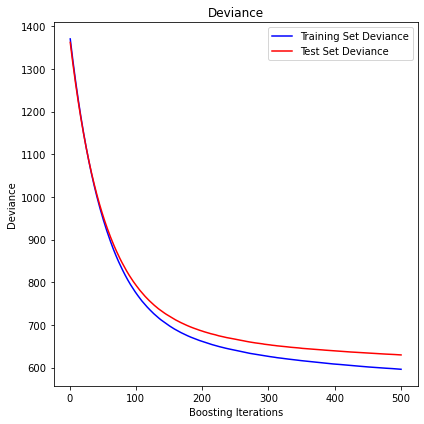

In [9]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [10]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -16.171 (0.291)


In [5]:
HGBR = ensemble.GradientBoostingRegressor()

In [6]:
# fine tuning the parameters by testing different values
param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'min_samples_split': [5, 10, 100, 500],
                  'n_estimators' : [100, 500, 1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

In [7]:
grid_GBR = HalvingGridSearchCV(HGBR, param_grid, resource='n_samples', max_resources='auto', random_state=0).fit(X_train, y_train)

In [8]:
print(" Results from Halving Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Halving Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500, subsample=0.5)

 The best score across ALL searched params:
 0.556396520820049

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.5}


In [24]:
new_params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    'subsample': 0.5,
    "loss": "squared_error",
}

In [25]:
reg2 = ensemble.GradientBoostingRegressor(**new_params)
reg2.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg2.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 628.9791


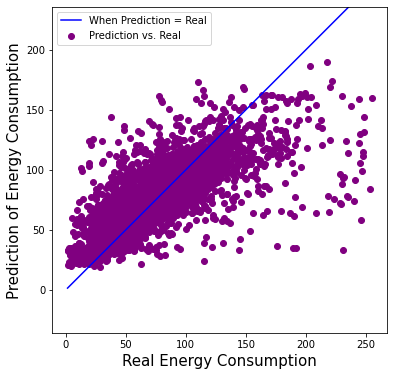

In [27]:
y_pred = reg2.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, c='purple', label="Prediction vs. Real")

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label="When Prediction = Real")
plt.xlabel('Real Energy Consumption', fontsize=15)
plt.ylabel('Prediction of Energy Consumption', fontsize=15)
plt.axis('equal')
plt.ylim(0, 200)

plt.legend(loc="upper left")